In [27]:
## Import necessary libraries
import pandas_datareader as pdr
import yfinance as yf
yf.pdr_override()
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import table

In [28]:
tick = ['AMZN', 'AAPL', 'NFLX', 'ADBE', 'GOOG',
          'MSFT', 'IBM', 'INTC', 'FB', 'TSLA']

In [29]:
price_data = list()
start_date = '2019-02-01'
end_date = '2021-02-01'

In [30]:
for index, ticker in enumerate(tick):
    prices = pdr.get_data_yahoo(ticker, start = start_date, end = end_date)
    price_data.append(prices.assign(ticker = ticker)[['Adj Close']])
df_stocks = pd.concat(price_data, axis=1)
df_stocks.columns=tick
df_stocks.head()

,AMZN,AAPL,NFLX,ADBE,GOOG,MSFT,IBM,INTC,FB,TSLA
Date,,,,,,,,,,
2019-01-31,1718.729980,40.582428,339.500000,247.820007,1116.369995,101.595657,120.269112,44.587032,166.690002,61.403999
2019-02-01,1626.229980,40.601936,339.850006,247.380005,1110.750000,99.990440,119.982819,46.110485,165.710007,62.442001
2019-02-04,1633.310059,41.755226,351.339996,254.740005,1132.800049,102.870094,120.958046,46.574154,169.250000,62.577999
2019-02-05,1658.810059,42.469643,355.809998,254.820007,1145.989990,104.309929,121.280167,47.321674,171.160004,64.269997
2019-02-06,1640.260010,42.484268,352.190002,254.350006,1115.229980,103.152237,121.969109,47.516888,170.490005,63.444000


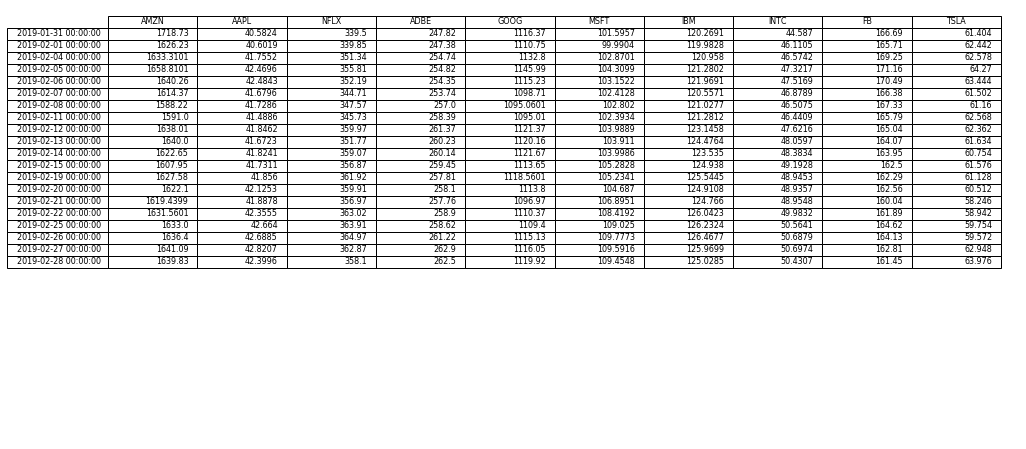

In [148]:
# set fig size
fig, ax = plt.subplots(figsize=(16, 8)) 
# no axes
ax.xaxis.set_visible(False)  
ax.yaxis.set_visible(False)  
# no frame
ax.set_frame_on(False)  
# plot table
tab = table(ax, df_stocks.head(20).round(4), loc='upper right')  
# set font manually
tab.auto_set_font_size(False)
tab.set_fontsize(8) 
# save the result
plt.savefig('table.png', dpi=500)

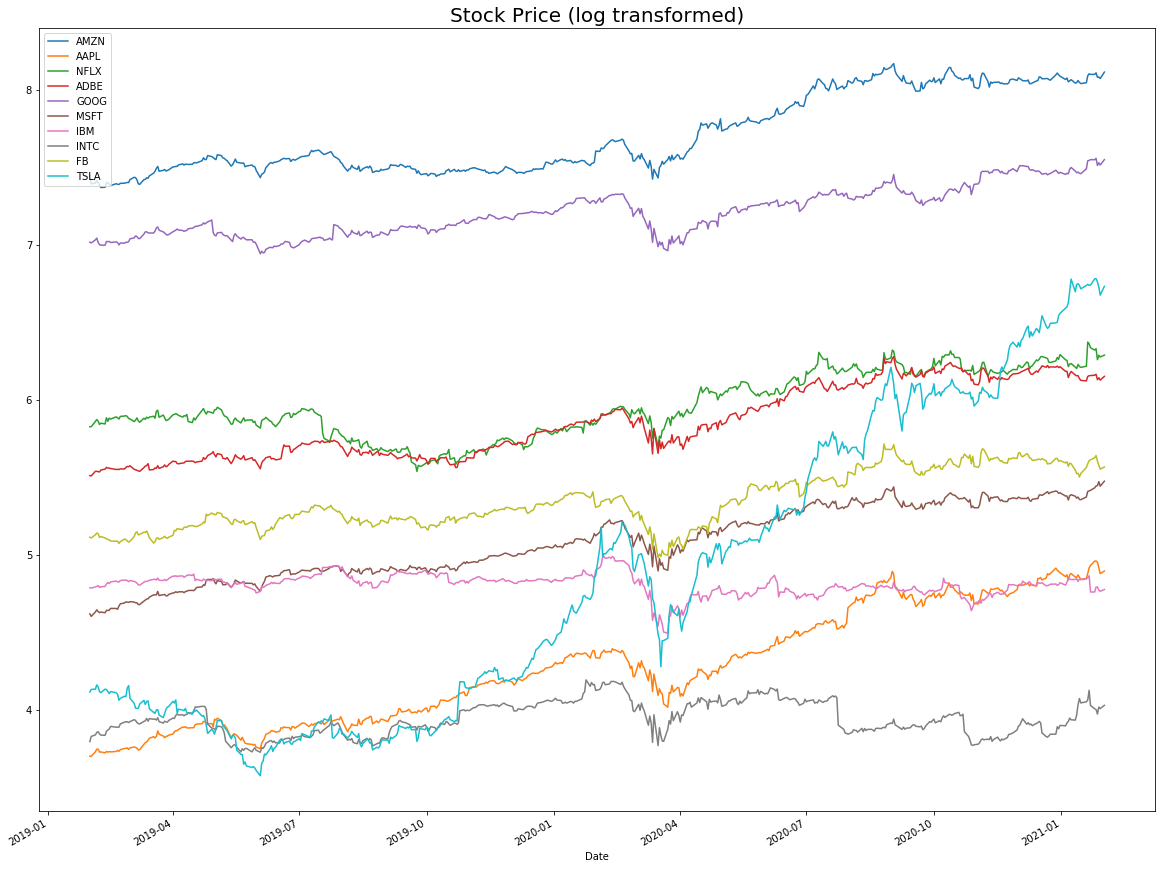

In [53]:
np.log(df_stocks).plot(figsize=(20, 16))
plt.title("Stock Price (log transformed)", size=20)
plt.legend(loc='upper left')
plt.savefig('output.png', dpi=100)
plt.show()

In [54]:
## Get S&P 500 data
sp = pdr.get_data_yahoo('^GSPC', start = start_date, end = end_date)[['Adj Close']]
sp['Return'] = np.log(sp['Adj Close']) - np.log(sp['Adj Close'].shift(1))
sp.head()

,Adj Close,Return
Date,,
2019-01-31,2704.100098,NaN
2019-02-01,2706.530029,0.000898
2019-02-04,2724.870117,0.006753
2019-02-05,2737.699951,0.004697
2019-02-06,2731.610107,-0.002227


In [55]:
## Perform train/test dataset split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_stocks, sp,test_size=0.20, shuffle=False)

In [56]:
## Trim risk-free rate to have the same trade dates as the stock info
rf_train = pdr.DataReader('DGS10', 'fred', start_date, X_train.index[-1])
rf_test = pdr.DataReader('DGS10', 'fred', X_train.index[-1], end_date)

In [57]:
rf_train = rf_train[rf_train.index.isin(X_train.index)].fillna(method ='ffill')
rf_test = rf_test[rf_test.index.isin(X_test.index)].fillna(method ='ffill')

In [58]:
## Compute daily log return of each stock
return_data = list()
for index, ticker in enumerate(tick):
    log_ret = np.log(X_train[ticker]) - np.log(X_train[ticker].shift(1))
    return_data.append(log_ret)
df_return = pd.concat(return_data, axis=1)
df_return.columns=tick
df_return.tail()

,AMZN,AAPL,NFLX,ADBE,GOOG,MSFT,IBM,INTC,FB,TSLA
Date,,,,,,,,,,
2020-08-31,0.014348,0.033350,0.010765,-0.005923,-0.006240,-0.014876,-0.014172,0.010259,-0.001568,0.118395
2020-09-01,0.013859,0.039060,0.049711,0.027966,0.016104,0.007686,0.000730,-0.003145,0.007611,-0.047822
2020-09-02,0.009197,-0.020936,-0.006688,0.011020,0.039882,0.019089,0.038004,0.028340,0.023615,-0.060034
2020-09-03,-0.047389,-0.083448,-0.050243,-0.049934,-0.051309,-0.063949,-0.029532,-0.036247,-0.038346,-0.094573
2020-09-04,-0.022028,0.000662,-0.018622,-0.031731,-0.031430,-0.014135,-0.017427,-0.006171,-0.029243,0.027434


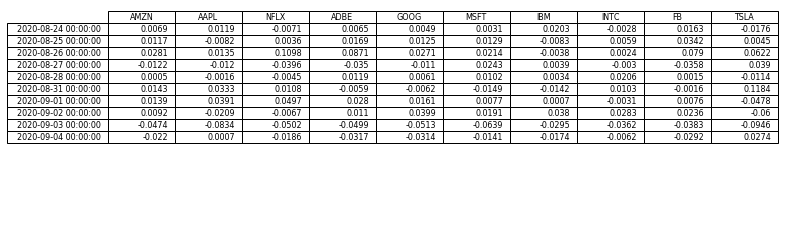

In [60]:
# set fig size
fig, ax = plt.subplots(figsize=(12, 4)) 
# no axes
ax.xaxis.set_visible(False)  
ax.yaxis.set_visible(False)  
# no frame
ax.set_frame_on(False)  
# plot table
tab = table(ax, df_return.tail(10).round(4), loc='upper right')  
# set font manually
tab.auto_set_font_size(False)
tab.set_fontsize(8) 
# save the result
plt.savefig('return_table.png', dpi=100)

In [62]:
## annualized return estimate Mean
def annual_return(df):
    mean_dict = dict()
    for col_name in df.columns:
        mean_dict[col_name] = (np.mean(df[col_name]) + 1) ** 252 - 1
        
    return mean_dict

In [63]:
## annualized sample covariance function
def cov_matrix(df):
    return df.cov() * 252

In [64]:
train_annual_return = annual_return(df_return)
train_mean_estimate_np = np.array(list(train_annual_return.values()))

In [65]:
train_cov_mat_estimate = cov_matrix(df_return)
train_cov_mat_estimate_np = train_cov_mat_estimate.to_numpy()

In [66]:
## Sample mean and standard deviation of S&P500 index (annualized)
sp_mean = (np.mean(y_train['Return']) + 1) ** 252 - 1
sp_vol = np.std(y_train['Return']) * np.sqrt(252)

In [67]:
## Sample mean and standard deviation of the risk-free rate (annualized)
rf_mean = np.mean(rf_train['DGS10'] / 100)
rf_vol = np.std(rf_train['DGS10'] / 100)

In [68]:
## Self-financing portfolio
def w_z(mu, sigma):
    e = np.ones(10)
    sigma_inv = np.linalg.inv(sigma)
    factor = (np.dot(e.T, np.dot(sigma_inv, mu))) / (np.dot(e.T, np.dot(sigma_inv, e)))
    return np.dot(sigma_inv, mu) - factor * np.dot(sigma_inv, e)

In [69]:
## Min-risk portfolio
def w_m(mu, sigma):
    e = np.ones(10)
    sigma_inv = np.linalg.inv(sigma)
    return (np.dot(sigma_inv, e)) / (np.dot(e.T, np.dot(sigma_inv, e)))

In [70]:
## Initialize a line vector of tau
tau_array = np.arange(0, 0.3, 0.01)

In [71]:
stocks_num = 10
tau_mean = np.zeros(len(tau_array))
tau_vol = np.zeros(len(tau_array))
all_weights = list()
for index, tau in enumerate(tau_array):
    weight_opt = tau * w_z(train_mean_estimate_np, train_cov_mat_estimate_np) + \
    w_m(train_mean_estimate_np, train_cov_mat_estimate_np)
    tau_mean[index] = np.sum((train_mean_estimate_np * weight_opt))
    tau_vol[index] = np.sqrt(np.dot(weight_opt.T, np.dot(train_cov_mat_estimate_np, weight_opt)))
    all_weights.append(weight_opt)

In [72]:
## naive portfolio
naive_weight = np.repeat(1 / stocks_num, stocks_num)
naive_mean = np.sum((train_mean_estimate_np * naive_weight))
naive_vol = np.sqrt(np.dot(naive_weight.T, np.dot(train_cov_mat_estimate_np, naive_weight)))

In [73]:
## Generate random portfolio to have a region of possible portfolios
np.random.seed(42)
num_ports = 50000
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)
for x in range(num_ports):
    # Weights
    weights = np.array(np.random.random(stocks_num) * 2 - 0.15)
    weights = weights/np.sum(weights)
    # Expected return
    ret_arr[x] = np.sum((train_mean_estimate_np * weights))
    # Expected volatility
    vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(train_cov_mat_estimate_np, weights)))
    # Sharpe Ratio
    sharpe_arr[x] = (ret_arr[x] - rf_mean)/vol_arr[x]

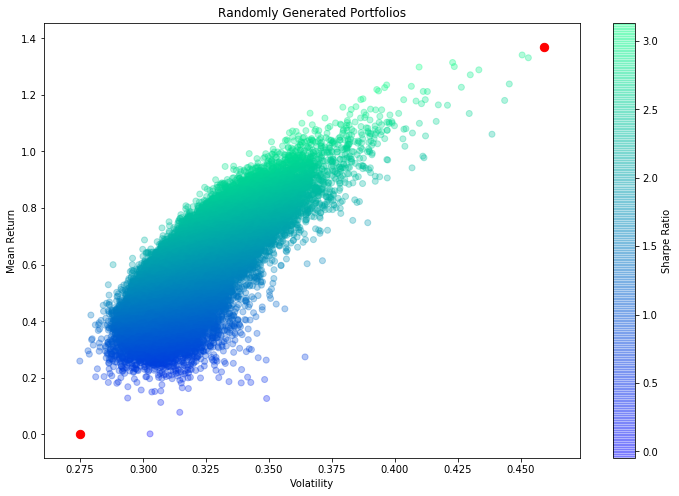

In [74]:
## Plot of random portfolios
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='winter', alpha=0.3)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Mean Return')
plt.scatter(vol_arr.max(), ret_arr.max(),c='red', s=70) # red dot
plt.scatter(vol_arr.min(), ret_arr.min(),c='red', s=70) # red dot
plt.savefig('random_portfolio.png')
plt.title('Randomly Generated Portfolios')
plt.show()

In [75]:
## define functions to get the empirical efficient frontier
from scipy.optimize import minimize
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum((train_mean_estimate_np * weights))
    vol = np.sqrt(np.dot(weights.T, np.dot(train_cov_mat_estimate_np, weights)))
    sr = ret/vol
    return np.array([ret, vol, sr])

In [76]:
def neg_sharpe(weights):
    # the number 2 is the sharpe ratio index from the get_ret_vol_sr
    return get_ret_vol_sr(weights)[2] * -1
def check_sum(weights):
    #return 0 if sum of the weights is 1
    return np.sum(weights)-1

In [77]:
frontier_y = np.arange(-0.1, 0.45, 0.001)
def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

In [78]:
frontier_x = []
init_guess = list(np.repeat(1 / stocks_num, stocks_num))
bounds = [(0,1)] * stocks_num

In [79]:
for possible_return in frontier_y:
    cons = ({'type':'eq', 'fun':check_sum},{'type':'eq', 'fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    result = minimize(minimize_volatility,init_guess,method='SLSQP', bounds=bounds, constraints=cons)
    frontier_x.append(result['fun'])

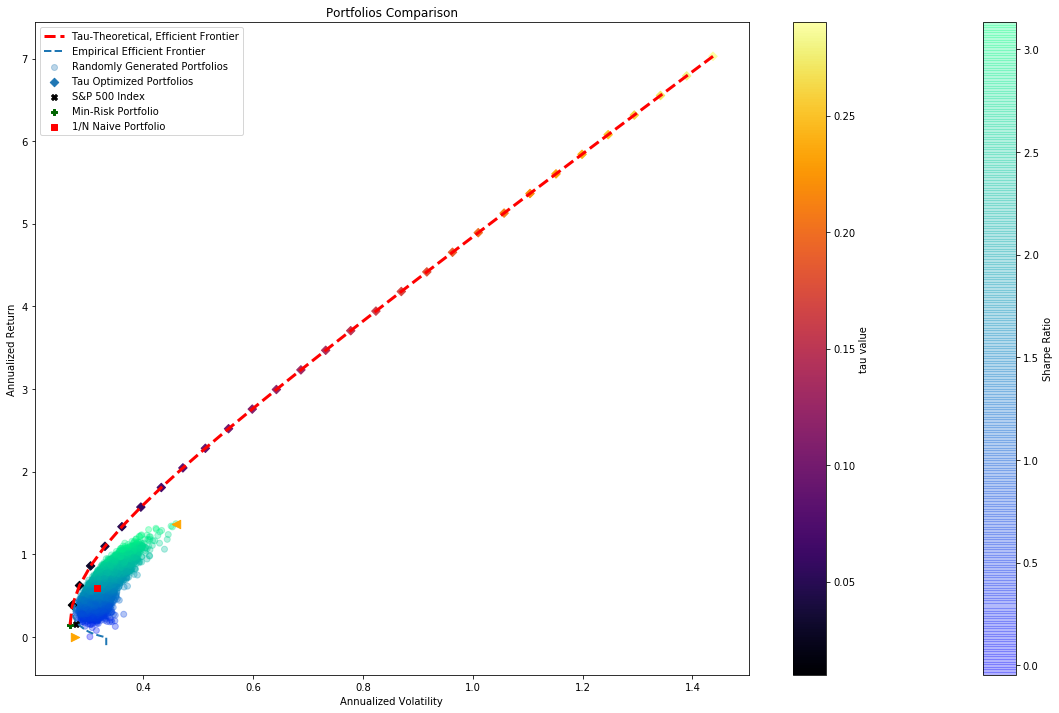

In [80]:
## plot everything and highlight portfolios
plt.figure(figsize=(20,12))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='winter', alpha = 0.3, label = "Randomly Generated Portfolios")
plt.colorbar(label='Sharpe Ratio')
plt.scatter(vol_arr.max(), ret_arr.max(),c='orange', marker = "<", s=70) # dot
plt.scatter(vol_arr.min(), ret_arr.min(),c='orange', marker = ">", s=70) # dot
plt.plot(tau_vol, tau_mean, 'r--', linewidth=3, label = "Tau-Theoretical, Efficient Frontier")
plt.scatter(tau_vol[1:], tau_mean[1:], c=tau_array[1:], cmap='inferno', marker = "D",
            label = "Tau Optimized Portfolios")
plt.colorbar(label='tau value')
plt.scatter(sp_vol, sp_mean, c = 'black', marker = "X", label = "S&P 500 Index")
plt.scatter(tau_vol[0], tau_mean[0], c = 'darkgreen', marker = "P", label = "Min-Risk Portfolio")
plt.scatter(naive_vol, naive_mean, c = 'red', marker = "s", label = "1/N Naive Portfolio")
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.plot(frontier_x,frontier_y, '--', linewidth=2, label = "Empirical Efficient Frontier")
plt.legend()
plt.title("Portfolios Comparison")
plt.savefig('EfficientFrontier.png')
plt.show()

In [81]:
## Regression models for beta
import statsmodels.api as sm
def ols_beta(ticker, df_x, df_y, r_f):
    ret_raw_stock = np.log(df_y[ticker]) - np.log(df_y[ticker].shift(1))
    ret_raw_stock = ret_raw_stock[1:] - r_f['DGS10'][1:]/100
    market_ret = np.array(df_x['Return'][1:] - r_f['DGS10'][1:]/100)
    X = sm.add_constant(market_ret[~np.isnan(market_ret)])
    Y = ret_raw_stock.dropna()
    OLS = sm.OLS(Y,X)
    results = OLS.fit()
    print(results.summary())
    return results.params[1]

def huber_beta(ticker, df_x, df_y, r_f):
    ret_raw_stock = np.log(df_y[ticker]) - np.log(df_y[ticker].shift(1))
    ret_raw_stock = ret_raw_stock[1:] - r_f['DGS10'][1:]/100
    market_ret = np.array(df_x['Return'][1:] - r_f['DGS10'][1:]/100)
    X = sm.add_constant(market_ret[~np.isnan(market_ret)])
    Y = ret_raw_stock.dropna()
    huber = sm.RLM(Y, X, M = sm.robust.norms.HuberT(1.345))
    results = huber.fit()
    print(results.summary())
    return results.params[1]

In [82]:
# Perform regressions
beta_dict = dict()
for ticker in tick:
    beta_dict[ticker] = np.array([ols_beta(ticker, y_train, X_train, rf_train),
                                  huber_beta(ticker, y_train, X_train, rf_train)])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     350.5
Date:                Thu, 25 Feb 2021   Prob (F-statistic):           1.26e-56
Time:                        13:03:58   Log-Likelihood:                 1119.2
No. Observations:                 402   AIC:                            -2234.
Df Residuals:                     400   BIC:                            -2226.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0027      0.001     -2.816      0.0

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     1200.
Date:                Thu, 25 Feb 2021   Prob (F-statistic):          1.73e-122
Time:                        13:03:58   Log-Likelihood:                 1244.4
No. Observations:                 402   AIC:                            -2485.
Df Residuals:                     400   BIC:                            -2477.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.001     -0.637      0.5

In [83]:
beta_df = pd.DataFrame.from_dict(beta_dict)
beta_df = beta_df.rename(index={0: 'OLS Beta', 1:'Robust Beta'})

In [84]:
beta_df

,AMZN,AAPL,NFLX,ADBE,GOOG,MSFT,IBM,INTC,FB,TSLA
OLS Beta,0.745664,1.112454,0.771834,1.091240,0.959981,1.095133,1.010423,1.158818,0.999575,1.256630
Robust Beta,0.803726,1.105014,0.836938,1.120185,0.956216,1.050985,1.050900,1.137859,0.981135,1.297581


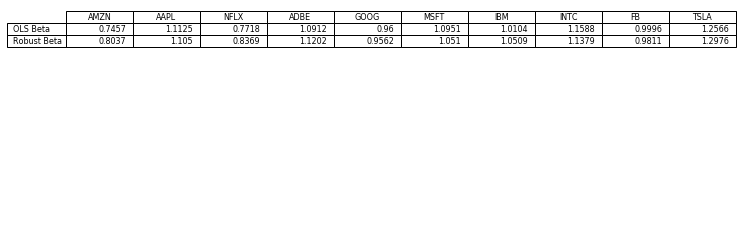

In [90]:
# set fig size
fig, ax = plt.subplots(figsize=(12, 4)) 
# no axes
ax.xaxis.set_visible(False)  
ax.yaxis.set_visible(False)  
# no frame
ax.set_frame_on(False)  
# plot table
tab = table(ax, beta_df.round(4), loc='upper right')  
# set font manually
tab.auto_set_font_size(False)
tab.set_fontsize(8) 
# save the result
plt.savefig('beta_table.png', dpi=200)

In [91]:
### Daily Return Calculation
from collections import OrderedDict
tau_opt_port_daily_ret_dict = OrderedDict()
for index, tau in enumerate(tau_array):
    weights = pd.Series(all_weights[index], index = tick)
    tau_opt_port_daily_ret_dict['tau=' + str(tau)] = (df_return * weights).sum(1)
    tau_opt_port_daily_ret_dict['1/N'] = (df_return * naive_weight).sum(1)
    tau_opt_port_daily_ret_dict['SPX'] = y_train[['Return']].sum(1)
    tau_opt_port_daily_ret_df = pd.DataFrame.from_dict(tau_opt_port_daily_ret_dict)

In [92]:
## Cumulative Return Calculation
cum_return_data = list()
for index, ticker in enumerate(tick):
    cum_ret = df_return[ticker].cumsum()
    cum_return_data.append(cum_ret)
    
df_ret_cum = pd.concat(cum_return_data, axis=1)
df_ret_cum.columns=tick

In [93]:
## Consolidate metrics
from collections import OrderedDict
tau_opt_port_cum_ret_dict = OrderedDict()
for index, tau in enumerate(tau_array):    
    weights = pd.Series(all_weights[index], index = tick)
    tau_opt_port_cum_ret_dict['tau=' + str(tau)] = (df_ret_cum * weights).sum(1)
    tau_opt_port_cum_ret_dict['1/N'] = (df_ret_cum * naive_weight).sum(1)
    tau_opt_port_cum_ret_dict['SPX'] = y_train[['Return']].cumsum().sum(1)
tau_opt_port_cum_ret_df = pd.DataFrame.from_dict(tau_opt_port_cum_ret_dict)

In [94]:
cols = tau_opt_port_cum_ret_df.columns.tolist()

In [130]:
col = ['tau=0.0', 'tau=0.01', 'tau=0.02', 'tau=0.03', 'tau=0.04', 'tau=0.05',
 'tau=0.06', 'tau=0.07', 'tau=0.08', 'tau=0.09', 'tau=0.1', 'tau=0.11', 'tau=0.12', 'tau=0.13',
 'tau=0.14', 'tau=0.15', 'tau=0.16', 'tau=0.17', 'tau=0.18', 'tau=0.19', 'tau=0.2', 'tau=0.21',
 'tau=0.22', 'tau=0.23', 'tau=0.24', 'tau=0.25', 'tau=0.26', 'tau=0.27', 'tau=0.28', 'tau=0.29', '1/N', 'SPX']

In [131]:
df = tau_opt_port_cum_ret_df[col]

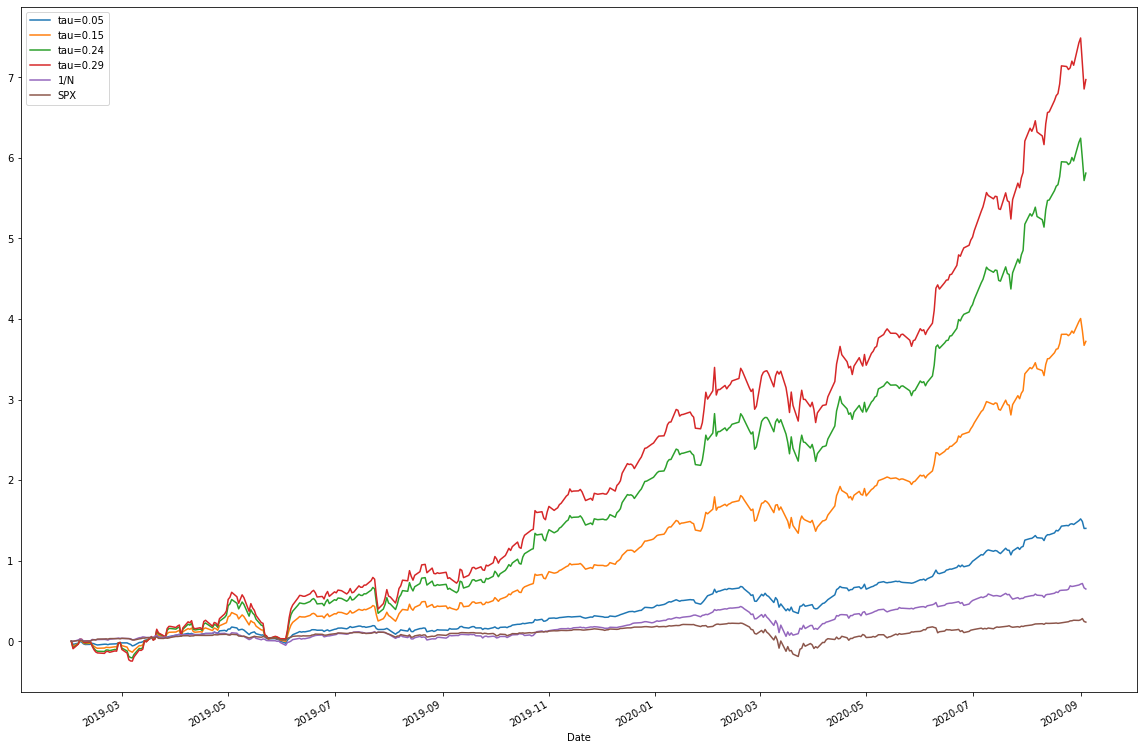

In [132]:
df[['tau=0.05','tau=0.15', 'tau=0.24', 'tau=0.29', '1/N', 'SPX']].plot(figsize=(20, 14))
plt.savefig("cumulative_return_train.png")

## dtale object to plot cumulative returns
dtale_summary = dtale.show(df, ignore_duplicate=True)
dtale_summary

In [133]:
def sharpe_ratio(mu, sigma, rf):
    return (mu - rf) / sigma
def treynor_ratio(mu, beta, rf):
    return (mu - rf) / beta
def jensen_alpha(mu, beta, rf, spm):
    return (mu - rf) - beta * (spm - rf)

In [134]:
metric_dict = OrderedDict()
def metric_summary(mu, sigma, beta, rf, spm):
    mean = mu
    vol = sigma
    sharpe = sharpe_ratio(mu, sigma, rf)
    treynor = treynor_ratio(mu, beta, rf)
    jensen = jensen_alpha(mu, beta, rf, spm)
    return [mean, vol, beta, sharpe, treynor, jensen]
for index, tau in enumerate(tau_array):
    weights = pd.Series(all_weights[index], index = tick)
    beta = (beta_df.T[['Robust Beta']].T * weights).sum(1)[0]
    metric_dict['tau=' + str(tau)] = metric_summary(tau_mean[index],tau_vol[index], beta, rf_mean, sp_mean)
    naive_beta = (beta_df.T[['Robust Beta']].T * naive_weight).sum(1)[0]
    metric_dict['1/N'] = metric_summary(naive_mean, naive_vol, naive_beta, rf_mean, sp_mean)
    metric_dict['SPX'] = metric_summary(sp_mean, sp_vol, 1, rf_mean, sp_mean)
    metric_df = pd.DataFrame.from_dict(metric_dict)
    metric_df = metric_df.rename(index={0: 'Mean Return', 1:'Standard Deviation', 2: 'Estimated Beta',3: 'Sharpe Ratio',
                                        4: 'Treynor Ratio', 5: 'Jensen Alpha'})

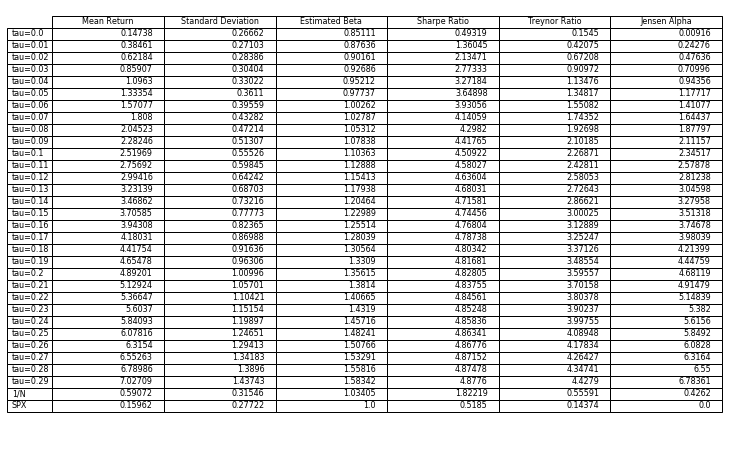

In [149]:
# set fig size
fig, ax = plt.subplots(figsize=(12, 8)) 
# no axes
ax.xaxis.set_visible(False)  
ax.yaxis.set_visible(False)  
# no frame
ax.set_frame_on(False)  
# plot table
tab = table(ax, metric_df[col].round(5).T, loc='upper right')  
# set font manually
tab.auto_set_font_size(False)
tab.set_fontsize(8) 
# save the result
plt.savefig('eval_train.png', dpi=200)

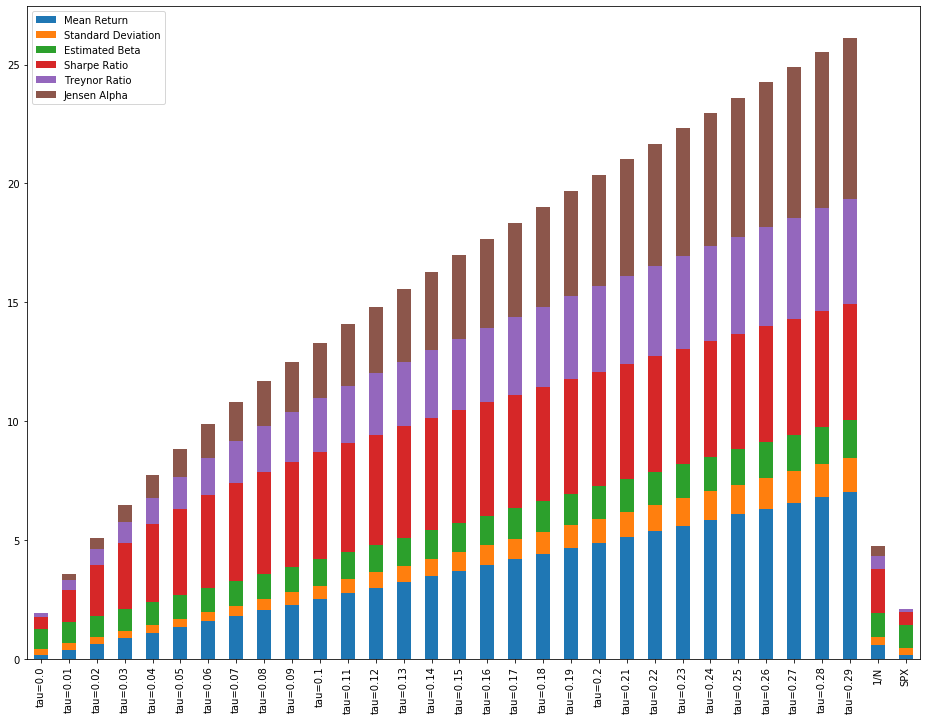

In [136]:
metric_df[col].T.plot(kind="bar", stacked=True, figsize=(16, 12))
plt.savefig('stacked_bar.png')

In [101]:
metric_df = metric_df[col].T
metric_df.index.name = "Tau"

In [102]:
## beta estimate on testing set
beta_dict_test = dict()
for ticker in tick:
    beta_dict_test[ticker] = np.array([ols_beta(ticker, y_test, X_test, rf_test), huber_beta(ticker, y_test, X_test, rf_test)])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     77.43
Date:                Thu, 25 Feb 2021   Prob (F-statistic):           4.86e-14
Time:                        13:18:59   Log-Likelihood:                 271.60
No. Observations:                 100   AIC:                            -539.2
Df Residuals:                      98   BIC:                            -534.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.002      0.883      0.3

                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  100
Model:                            RLM   Df Residuals:                       98
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 25 Feb 2021                                         
Time:                        13:18:59                                         
No. Iterations:                    17                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.002      0.369      0.7

In [103]:
beta_df_test = pd.DataFrame.from_dict(beta_dict_test)
beta_df_test = beta_df_test.rename(index={0: 'OLS Beta', 1:'Robust Beta'})

In [104]:
beta_df_test

,AMZN,AAPL,NFLX,ADBE,GOOG,MSFT,IBM,INTC,FB,TSLA
OLS Beta,1.317109,1.410327,1.122791,1.194949,1.300392,1.210143,0.698572,0.899909,1.335649,1.642546
Robust Beta,1.264736,1.479786,1.038952,1.203449,1.302340,1.291413,0.706120,0.884308,1.275903,1.571678


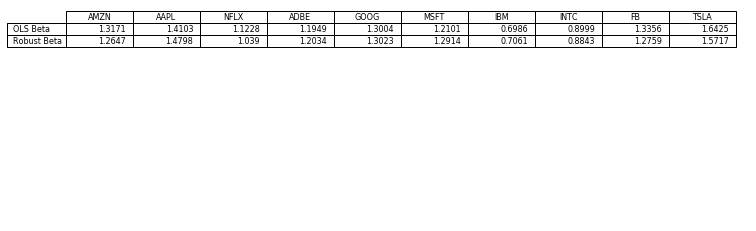

In [127]:
# set fig size
fig, ax = plt.subplots(figsize=(12, 4)) 
# no axes
ax.xaxis.set_visible(False)  
ax.yaxis.set_visible(False)  
# no frame
ax.set_frame_on(False)  
# plot table
tab = table(ax, beta_df_test.round(4), loc='upper right')  
# set font manually
tab.auto_set_font_size(False)
tab.set_fontsize(8) 
# save the result
plt.savefig('test_beta.png', dpi=200)

In [105]:
return_data_test = list()
for index, ticker in enumerate(tick):
    log_ret = np.log(X_test[ticker]) - np.log(X_test[ticker].shift(1))
    return_data_test.append(log_ret)
df_ret_test = pd.concat(return_data_test, axis=1)
df_ret_test.columns=tick
df_ret_test.tail()

,AMZN,AAPL,NFLX,ADBE,GOOG,MSFT,IBM,INTC,FB,TSLA
Date,,,,,,,,,,
2021-01-26,0.009707,0.001678,0.009207,0.005981,0.009349,0.012125,0.032441,-0.004157,0.014427,0.002597
2021-01-27,-0.028529,-0.007713,-0.071261,-0.034779,-0.046139,0.002450,-0.000163,-0.029782,-0.035768,-0.021669
2021-01-28,0.001558,-0.035612,0.028856,0.012251,0.017500,0.025561,-0.019708,0.045238,-0.026587,-0.033811
2021-01-29,-0.009752,-0.038139,-0.011597,-0.014928,-0.014799,-0.029606,-0.008111,-0.010038,-0.025492,-0.051455
2021-02-01,0.041746,0.016385,0.012413,0.024184,0.035116,0.032615,0.011934,0.021035,0.014145,0.056684


In [106]:
## mean return, sample variance, sample covariance of test sets
test_mean_estimate = annual_return(df_ret_test)
test_mean_estimate_np = np.array(list(test_mean_estimate.values()))
test_cov_mat_estimate = cov_matrix(df_ret_test)
test_cov_mat_estimate_np = test_cov_mat_estimate.to_numpy()
tau_mean_test = np.zeros(len(tau_array))
tau_vol_test = np.zeros(len(tau_array))
for index, tau in enumerate(tau_array):
    weight_opt = all_weights[index]
    tau_mean_test[index] = np.sum((test_mean_estimate_np * weight_opt))
    tau_vol_test[index] = np.sqrt(np.dot(weight_opt.T, np.dot(test_cov_mat_estimate_np, weight_opt)))
naive_mean_test = np.sum((test_mean_estimate_np * naive_weight))
naive_vol_test = np.sqrt(np.dot(naive_weight.T, np.dot(test_cov_mat_estimate_np, naive_weight)))

In [107]:
sp_mean_test = (np.mean(y_test['Return']) + 1) ** 252 - 1
sp_vol_test = np.std(y_test['Return']) * np.sqrt(252)
rf_mean_test = np.mean(rf_test['DGS10'] / 100)
rf_vol_test = np.std(rf_test['DGS10'] / 100)

In [108]:
### Daily Return Calculation
tau_opt_port_daily_ret_dict = OrderedDict()
for index, tau in enumerate(tau_array):
    weights = pd.Series(all_weights[index], index = tick)
    tau_opt_port_daily_ret_dict['tau=' + str(tau)] = (df_ret_test * weights).sum(1)
    tau_opt_port_daily_ret_dict['1/N'] = (df_ret_test * naive_weight).sum(1)
    tau_opt_port_daily_ret_dict['SPX'] = y_test[['Return']].sum(1)
    tau_opt_port_daily_ret_df_test = pd.DataFrame.from_dict(tau_opt_port_daily_ret_dict)

In [109]:
df_t = tau_opt_port_daily_ret_df_test[col]

In [110]:
df_t

,tau=0.0,tau=0.01,tau=0.02,tau=0.03,tau=0.04,tau=0.05,tau=0.06,tau=0.07,tau=0.08,tau=0.09,...,tau=0.22,tau=0.23,tau=0.24,tau=0.25,tau=0.26,tau=0.27,tau=0.28,tau=0.29,1/N,SPX
Date,,,,,,,,,,,,,,,,,,,,,
2020-09-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.028149
2020-09-09,0.010401,0.021062,0.031723,0.042384,0.053045,0.063706,0.074368,0.085029,0.095690,0.106351,...,0.244946,0.255607,0.266269,0.276930,0.287591,0.298252,0.308913,0.319574,0.029309,0.019945
2020-09-10,-0.026752,-0.027848,-0.028943,-0.030039,-0.031135,-0.032230,-0.033326,-0.034421,-0.035517,-0.036612,...,-0.050855,-0.051951,-0.053046,-0.054142,-0.055238,-0.056333,-0.057429,-0.058524,-0.018774,-0.017741
2020-09-11,-0.005745,-0.008604,-0.011462,-0.014321,-0.017180,-0.020039,-0.022897,-0.025756,-0.028615,-0.031474,...,-0.068638,-0.071496,-0.074355,-0.077214,-0.080073,-0.082931,-0.085790,-0.088649,-0.004130,0.000533
2020-09-14,-0.011537,-0.001705,0.008126,0.017958,0.027790,0.037622,0.047453,0.057285,0.067117,0.076949,...,0.204761,0.214593,0.224425,0.234257,0.244088,0.253920,0.263752,0.273584,0.017407,0.012661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-26,0.020128,0.017737,0.015346,0.012956,0.010565,0.008174,0.005783,0.003392,0.001001,-0.001390,...,-0.032471,-0.034862,-0.037253,-0.039643,-0.042034,-0.044425,-0.046816,-0.049207,0.009335,-0.001490
2021-01-27,-0.029400,-0.024251,-0.019102,-0.013953,-0.008804,-0.003655,0.001494,0.006643,0.011792,0.016941,...,0.083877,0.089026,0.094175,0.099324,0.104473,0.109622,0.114771,0.119920,-0.027335,-0.026013
2021-01-28,-0.004682,-0.011997,-0.019311,-0.026626,-0.033941,-0.041255,-0.048570,-0.055885,-0.063199,-0.070514,...,-0.165605,-0.172919,-0.180234,-0.187549,-0.194863,-0.202178,-0.209493,-0.216807,0.001525,0.009713


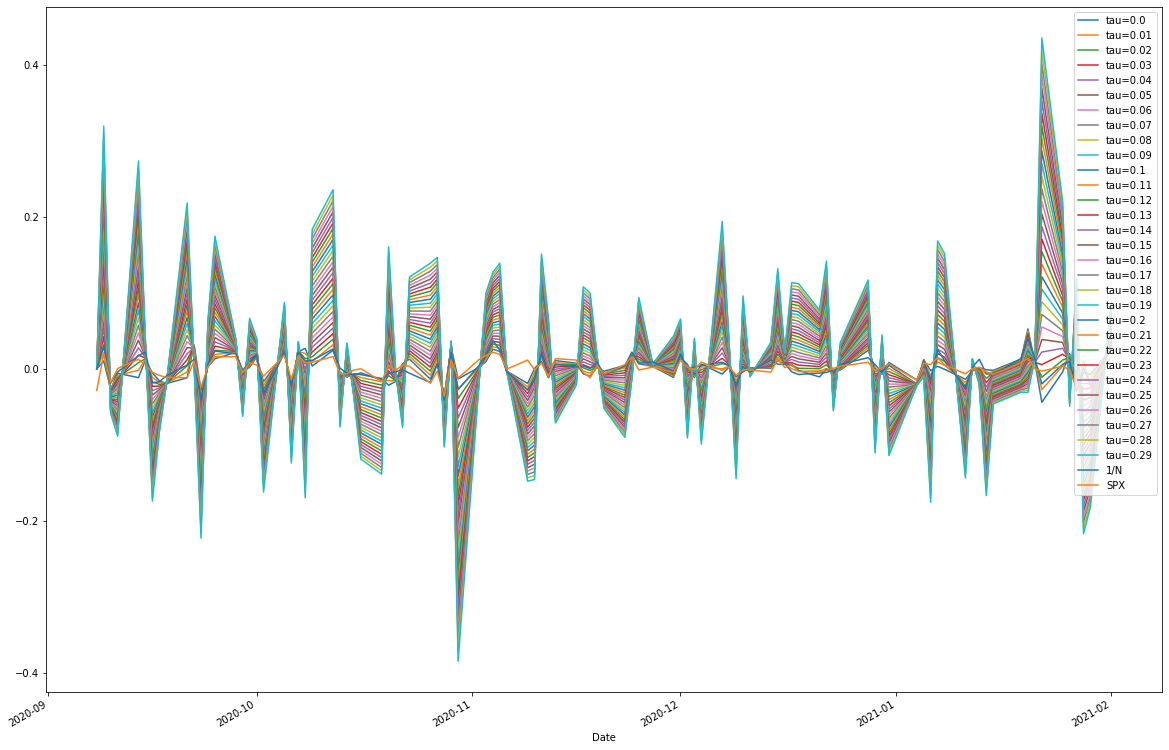

In [111]:
df_t.plot(figsize=(20,14))
plt.show()

In [112]:
## Cumulative Return Calculation
cum_return_data = list()
for index, ticker in enumerate(tick):
    cum_ret = df_ret_test[ticker].cumsum()
    cum_return_data.append(cum_ret)
df_ret_cum_test = pd.concat(cum_return_data, axis=1)
df_ret_cum_test.columns=tick

In [113]:
tau_opt_port_cum_ret_dict = OrderedDict()
for index, tau in enumerate(tau_array):
    weights = pd.Series(all_weights[index], index = tick)
    tau_opt_port_cum_ret_dict['tau=' + str(tau)] = (df_ret_cum_test * weights).sum(1)

In [114]:
tau_opt_port_cum_ret_dict['1/N'] = (df_ret_cum_test * naive_weight).sum(1)

In [115]:
tau_opt_port_cum_ret_dict['SPX'] = y_test[['Return']].cumsum().sum(1)
tau_opt_port_cum_ret_df_test = pd.DataFrame.from_dict(tau_opt_port_cum_ret_dict)

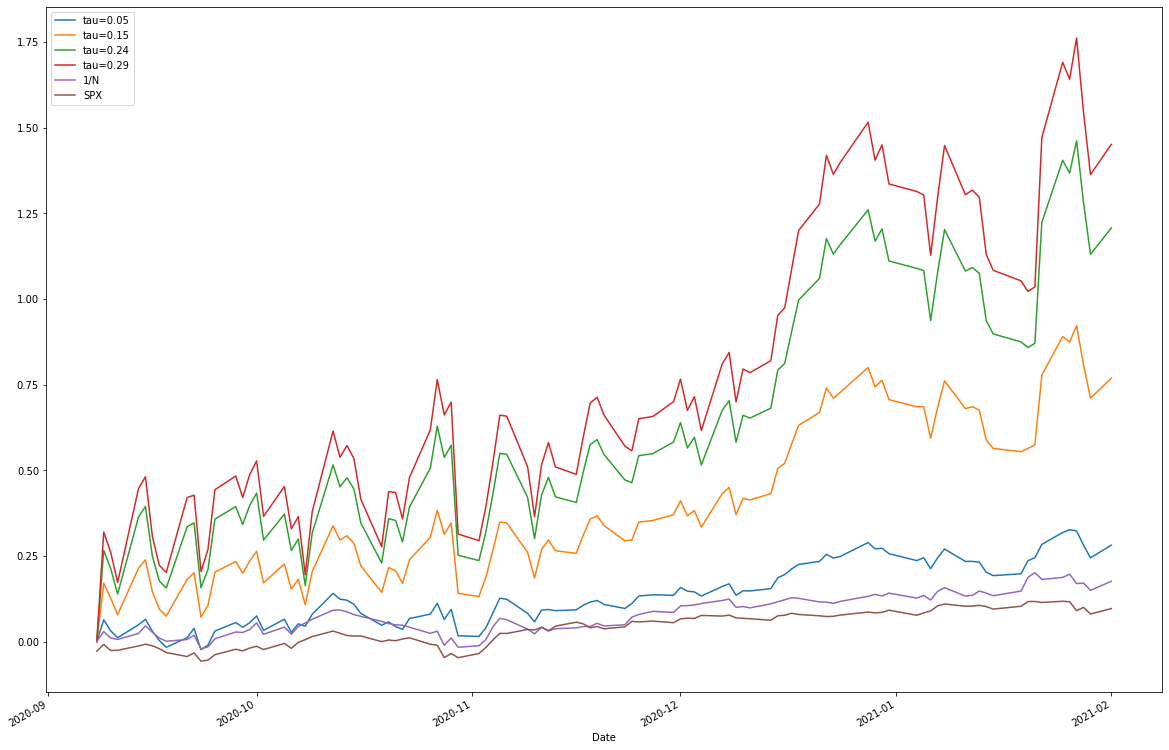

In [116]:
tau_opt_port_cum_ret_df_test[['tau=0.05','tau=0.15', 'tau=0.24', 'tau=0.29', '1/N', 'SPX']].plot(figsize=(20, 14))
plt.savefig("cumulative_return_test.png")

In [117]:
metric_dict = OrderedDict()
for index, tau in enumerate(tau_array):
    weights = pd.Series(all_weights[index], index = tick)
    beta = (beta_df_test.T[['Robust Beta']].T * weights).sum(1)[0]
    metric_dict['tau=' + str(tau)] = metric_summary(tau_mean_test[index], tau_vol_test[index], beta, rf_mean_test, sp_mean_test)

In [118]:
naive_beta = (beta_df_test.T[['Robust Beta']].T * naive_weight).sum(1)[0]
metric_dict['1/N'] = metric_summary(naive_mean_test, naive_vol_test, naive_beta, rf_mean_test, sp_mean_test)
metric_dict['SPX'] = metric_summary(sp_mean_test, sp_vol_test, 1, rf_mean_test, sp_mean_test)
metric_df_test = pd.DataFrame.from_dict(metric_dict)
metric_df_test = metric_df_test.rename(index={0: 'Mean Return', 1:'Standard Deviation', 2: 'Estimated Beta',3: 'Sharpe Ratio', 4: 'Treynor Ratio', 5: 'Jensen Alpha'})

In [119]:
metric_df_test = metric_df_test.T
metric_df_test

,Mean Return,Standard Deviation,Estimated Beta,Sharpe Ratio,Treynor Ratio,Jensen Alpha
tau=0.0,-0.084587,0.245177,1.025517,-0.380777,-0.091035,-0.363147
tau=0.01,0.343021,0.254703,1.138557,1.312315,0.293574,0.034723
tau=0.02,0.770629,0.282056,1.251597,2.701093,0.608709,0.432593
tau=0.03,1.198238,0.322734,1.364638,3.685597,0.871636,0.830464
tau=0.04,1.625846,0.372396,1.477678,4.342355,1.094336,1.228334
tau=0.05,2.053455,0.427926,1.590718,4.778132,1.285384,1.626204
tau=0.06,2.481063,0.487321,1.703758,5.073235,1.451082,2.024074
tau=0.07,2.908672,0.549329,1.816799,5.278985,1.596160,2.421945
tau=0.08,3.336280,0.613159,1.929839,5.426832,1.724242,2.819815
tau=0.09,3.763889,0.678295,2.042879,5.536111,1.838150,3.217685


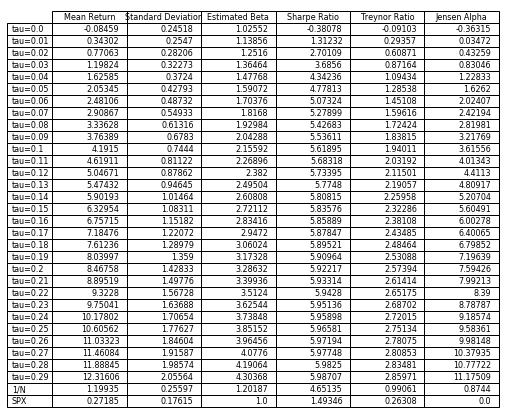

In [146]:
# set fig size
fig, ax = plt.subplots(figsize=(8, 4)) 
# no axes
ax.xaxis.set_visible(False)  
ax.yaxis.set_visible(False)  
# no frame
ax.set_frame_on(False)  
# plot table
tab = table(ax, metric_df_test.round(5), loc='upper right')  
# set font manually
tab.auto_set_font_size(False)
tab.set_fontsize(8) 
# save the result
plt.savefig('eval_test.png', dpi=200)

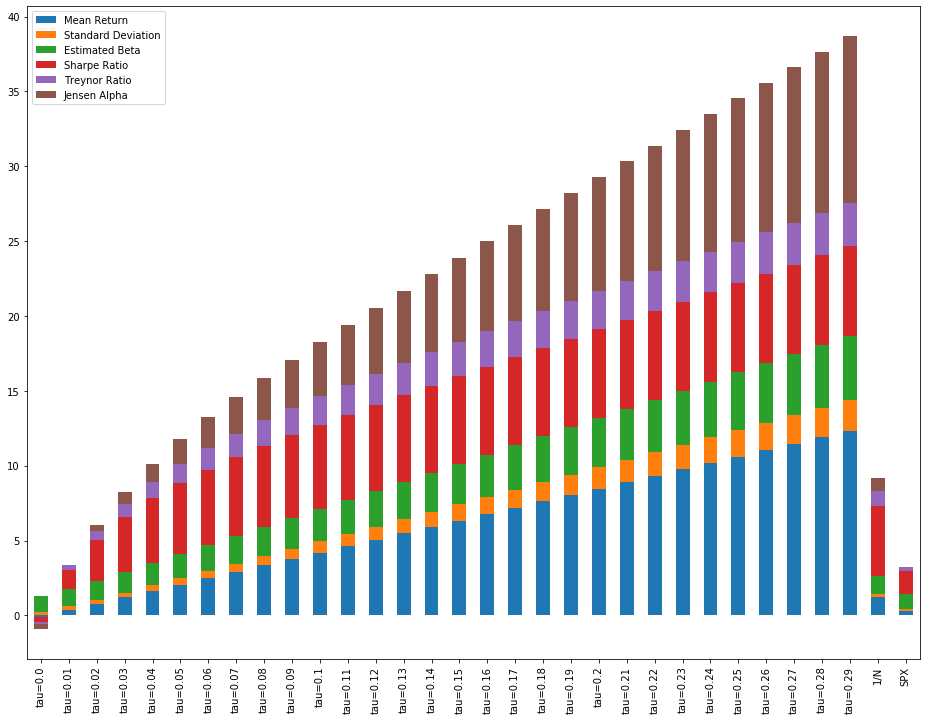

In [120]:
metric_df_test.plot(kind="bar", stacked=True, figsize=(16, 12))
plt.savefig('stacked_bar_test.png')

In [121]:
weights_df = pd.DataFrame(data = all_weights)
weights_df.columns = tick
weights_df.index = tau_array

In [122]:
weights_df.index.name = "Tau"

In [124]:
weights_df = pd.DataFrame(data = all_weights )


In [125]:
weights_df.columns = tick
weights_df.index = metric_df_test.index[:-2]


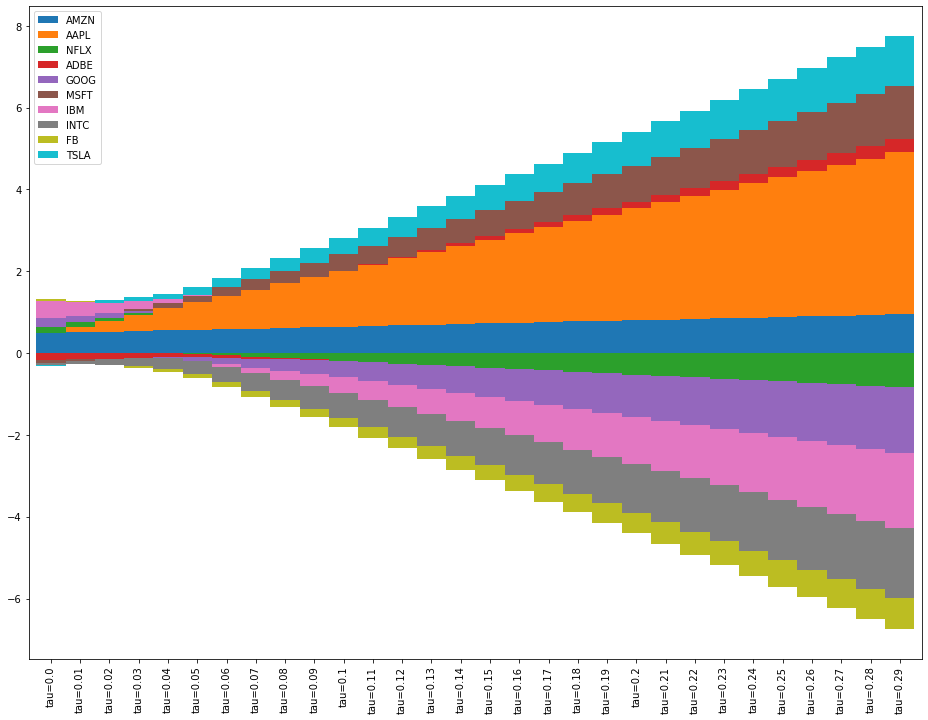

In [126]:
weights_df.plot(kind="bar", width=1, stacked=True, figsize=(16, 12))
plt.savefig("weights.png")
plt.show()